# 2.5D DC Resistivity Forward Simulation

This tutorial demonstrates the forward simulation of DC resistivity data with SimPEG. We define surface topography, survey geometry, and subsurface electrical resistivity for a 2.5D geometry. We use this information to simulate normalized voltage data.

The following items are discussed in this tutorial:

- Defining surface topography.
- Defining surveys within SimPEG.
- Defining the mesh on which the forward simulation is solved.
- Defining a model which represents Earth's subsurface resistivity.
- Defining the forward simulation.
- Plotting DC resistivity data.

<img src="https://raw.githubusercontent.com/simpeg/agrogeo24/main/images/dcr_fwd.png" width="100%" align="center"/>

## Step 0: Importing Modules

Here, we import all of the functionality required to run the notebook for the tutorial exercise. All of the functionality specific to DC resistivity is imported from [SimPEG.electromagnetics.static.resistivity](https://docs.simpeg.xyz/content/api/SimPEG.electromagnetics.static.resistivity.html).
We also import some useful utility functions from [SimPEG.utils](https://docs.simpeg.xyz/content/api/SimPEG.utils.html). To simulate DC resistivity data, we need to define our problem geometry on a numerical grid (or mesh).
To generate the mesh, we used the [discretize](https://discretize.simpeg.xyz/en/main) package.

In [1]:
# SimPEG functionality
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.utils import model_builder
from SimPEG.utils.io_utils.io_utils_electromagnetics import write_dcip2d_ubc
from SimPEG import maps, data
from SimPEG.electromagnetics.static.utils.static_utils import (
    generate_dcip_sources_line,
    pseudo_locations,
    plot_pseudosection,
    apparent_resistivity_from_voltage,
)

# discretize functionality
from discretize import TreeMesh
from discretize.utils import active_from_xyz

# Common Python functionality
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

mpl.rcParams.update({"font.size": 14})  # default font size

write_output = True  # Optional

## Step 1: Defining Topography

Defining the topography is a good first step when setting up the forward simulation. It gives the user a sense of the scale of the problem and is easy to plot. For a 2.5D simulation, topography is defined as an (N, 2) *numpy.ndarray*, where the first coordinate represent along-line position, the second coordinate represents the vertical position, and we assume the topography does not change along the a 3rd orthogonal direction. The 2.5D simulations work well in modeling cases like the one pictured below (Alagbo et al., 2022, Figure 5), which is provided under the CC-BY-4.0 license.

<img src="https://www.researchgate.net/profile/Oyebanji-Alagbo-2/publication/359861220/figure/fig1/AS:1143365911478274@1649611084348/Schematic-description-of-ridge-tillage-with-crops-placed-on-top-of-the-re-compacted.png" width="70%" align="center"/>

### <span style="color:darkgreen">Exercise (beginner):</span>

Define a topography over x = (-300, 300) with a 1 m horizontal spacing. Let the elevation $y = 4 + 4 \, tanh(x/100)$. Use the variable name *topo_2d* to define the (N, 2) numpy array for the topography.

In [2]:
# Along-line locations
x_topo = np.arange(-300.0, 300.0, 1.0)

# Elevation as a function of along-line location
y_topo = 4.0 + 4.0 * np.tanh(x_topo / 100)

# Define full 2D topography
topo_2d = np.c_[x_topo, y_topo]

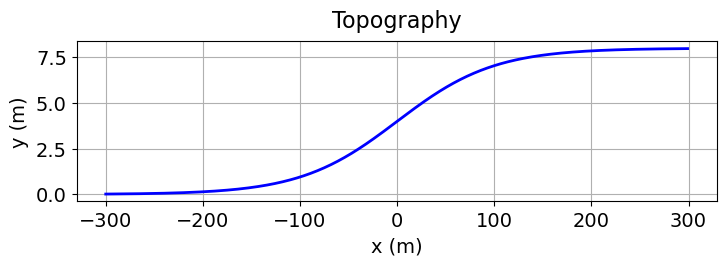

In [3]:
# Plot 2D topography
fig = plt.figure(figsize=(8, 2))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(topo_2d[:, 0], topo_2d[:, -1], color="b", linewidth=2)
ax.set_xlabel("x (m)", labelpad=5)
ax.set_ylabel("y (m)", labelpad=5)
ax.grid(True)
ax.set_title("Topography", fontsize=16, pad=10)
plt.show(fig)

## Step 2: Defining the Survey

<img src="https://raw.githubusercontent.com/simpeg/agrogeo24/main/images/DCR_DipoleDipole_Array.svg" width="43%" align="right"/>

DC resistivity surveys within SimPEG require the user to create and connect three types of objects:

- [receivers](https://docs.simpeg.xyz/content/api/SimPEG.electromagnetics.static.resistivity.html#receivers): which defines the locations of the potential (or MN) electrodes and the type of data; e.g. 'volt' for normalized voltage (V/A), 'apparent_resistivity' for apparent resistivity ($\Omega m$) or 'apparent_chargeability' for apparent chargeability (unitless). *Note only M electrode locations are needed to define pole receivers*.
- [sources](https://docs.simpeg.xyz/content/api/SimPEG.electromagnetics.static.resistivity.html#sources): which defines the locations of the current (or AB) electrodes, and their associated receivers. *Note only A electrode locations are needed to define pole sources*.
- [survey](https://docs.simpeg.xyz/content/api/SimPEG.electromagnetics.static.resistivity.html#survey): the object which stores and organizes all of the sources and receivers.

Using SimPEG, there are three approaches one might use to generate a 2.5D resistivity survey.

1. Define the source objects and associated receiver objects manually within a for loop, then assign to a survey
2. Use the [generate_survey_from_abmn_locations](https://docs.simpeg.xyz/content/api/generated/SimPEG.electromagnetics.static.utils.generate_survey_from_abmn_locations.html#SimPEG.electromagnetics.static.utils.generate_survey_from_abmn_locations) to generate the survey automatically from a set of A, B, M, N electrode locations.
3. Use the [generate_dcip_sources_line](https://docs.simpeg.xyz/content/api/generated/SimPEG.electromagnetics.static.utils.generate_dcip_sources_line.html#SimPEG.electromagnetics.static.utils.generate_dcip_sources_line) utility function to define the source list for survey lines automatically.


### <span style="color:darkgreen">Exercise (beginner):</span>

Use the [generate_dcip_sources_line](myst:SimPEG#SimPEG.electromagnetics.static.utils.generate_dcip_sources_line) utility function to define a DC resistivity survey line. Enter the following input arguments, in order:

* **'dipole-dipole'** (survey type)
* **'volt'** (data type)
* **'2D'** (dimension of the problem)
* **[-65, 65]** (horizontal end locations)
* **topo_2d** (our topography object)
* **15** (number of receivers per source)
* **5** (electrode spacing)

This will output a list of source objects with associated receivers. Then define a [dc.Survey](https://docs.simpeg.xyz/content/api/SimPEG.electromagnetics.static.resistivity.html#survey) the object which stores and organizes all of the sources and receivers.

### <span style="color:darkorange">Exercise (advanced):</span>

Try different electrode configurations in your survey (e.g. 'pole-dipole'). Or change the number of receivers or the electrode spacing.

In [4]:
# Define survey line parameters
survey_type = "dipole-dipole"
dimension_type = "2D"
data_type = "volt"
end_locations = [-65.0, 65.0]
num_rx_per_src = 15
station_separation = 5.0

In [5]:
# Generate source list for DC survey line
source_list = generate_dcip_sources_line(
    survey_type,
    data_type,
    dimension_type,
    end_locations,
    topo_2d,
    num_rx_per_src,
    station_separation,
)

In [6]:
survey = dc.Survey(source_list, survey_type=survey_type)

We can plot the pseudo-locations to get an idea of where on the Earth we are sampling. Shifting the electrode locations laterally gives us horizontal information. Larger electrode spacings gives us information at depth.

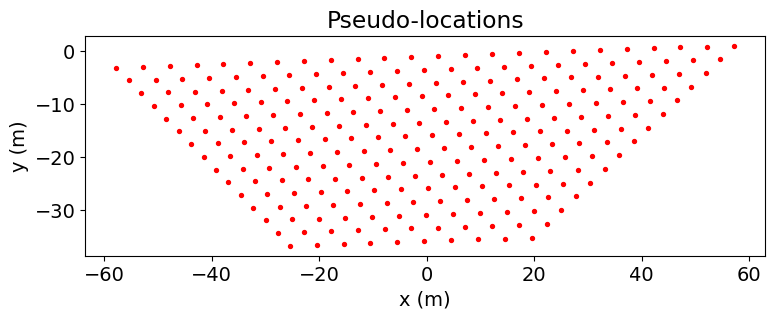

In [7]:
pseudo_locations_xy = pseudo_locations(survey)
fig = plt.figure(figsize=(8, 2.75))
ax = fig.add_axes([0.1, 0.1, 0.85, 0.8])
ax.scatter(pseudo_locations_xy[:, 0], pseudo_locations_xy[:, -1], 8, "r")
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_title("Pseudo-locations")
plt.show()

### <span style="color:darkgreen">Exercise (beginner):</span>

We can extract various objects and properties from the survey object. Try to extract the following items from the survey object:

- the total number of data
- the electrode locations
- the 3rd receiver of the 2nd source

## Step 3: Designing a Mesh

Meshes define the numerical grid on which we numerically solve the PDE for the DC resistivity problem. Meshes are designed using the [discretize](https://discretize.simpeg.xyz/en/main) package. See the [discretize user tutorials](https://discretize.simpeg.xyz/en/main/tutorials/mesh_generation/index.html) to learn more about creating meshes.
Here, the forward simulation is computed for a [tree mesh](https://discretize.simpeg.xyz/en/main/api/generated/discretize.TreeMesh.html).

<img src="https://raw.githubusercontent.com/simpeg/agrogeo24/main/images/sphx_glr_1_mesh_overview_001.png" width="75%" align="center"/>


The electric potential produced by a current electrode falls off as $r^{-3}$. So smaller cells are needed near the current electrodes to model the fields accurately, and larger cells can be used away from the current electrodes where the fields are smooth. Tree meshes are well-suited for DC (and IP) simulation because the cell size can be increased at specified distances from the current electrodes. For DC resistivity meshing, we advise the following considerations and rules of thumb:

1. Because there are no currents in the air, we do not need to pad upwards. I.e. the top of the mesh corresponds to the top of the topography.
2. We require at least 2-3 cells between each current electrode; with more accurate results being obtained when the minimum cell size is smaller. For a 2.5D problem geometry, we can discretize much finer.
3. To be safe, the padding thickness should be at least 2-3 times the largest electrode spacing. 
4. The increase in cell size at increasing distances from the current electrodes should not happen too abruptly. At each cell size, you should have a layer at least 4 cells thick before increasing the cell size.
5. Finer discretization is required when topography is significant.

### <span style="color:darkgreen">Exercise (beginner):</span>

Define and provide reasonable values for the following variables:

* **dh** (minimum cell width)
* **dom_width_x** (width of the domain along x)
* **dom_width_y** (width of the domain along y)

### <span style="color:darkorange">Exercise (advanced):</span>

Play with the parameters of the [refine_surface](https://discretize.simpeg.xyz/en/main/api/generated/discretize.TreeMesh.refine_surface.html) and [refine_points](https://discretize.simpeg.xyz/en/main/api/generated/discretize.TreeMesh.refine_points.html) methods to change the level of discretization around the surface and the electrode locations. Or visit the [tree mesh](https://discretize.simpeg.xyz/en/main/api/generated/discretize.TreeMesh.html) API to see additional refinement methods.

In [8]:
# LEAVE CELL PARTIALLY BLANK

dh = 0.5  # base cell width
dom_width_x = 800.0  # domain width x
dom_width_y = 400.0  # domain width z

In [9]:
# Number of base cells along x and y
nbcx = 2 ** int(np.round(np.log(dom_width_x / dh) / np.log(2.0)))
nbcy = 2 ** int(np.round(np.log(dom_width_y / dh) / np.log(2.0)))

# Define the base mesh with top at z = 0 m.
hx = [(dh, nbcx)]
hy = [(dh, nbcy)]
mesh = TreeMesh([hx, hy], origin="CN")

# Shift top to maximum topography and center of survey line
mesh.origin = mesh.origin + np.r_[np.mean(end_locations), y_topo.max()]

In [10]:
# Mesh refinement near electrodes.
unique_locations = survey.unique_electrode_locations

mesh.refine_points(
    unique_locations, padding_cells_by_level=[10, 8, 8, 8, 4, 4], finalize=False
)

# Mesh refinement based on topography
mesh.refine_surface(
    topo_2d[np.abs(x_topo) < 150.0, :],
    padding_cells_by_level=[0, 0, 4, 4],
    finalize=False,
)

In [11]:
# Finalize
mesh.finalize()

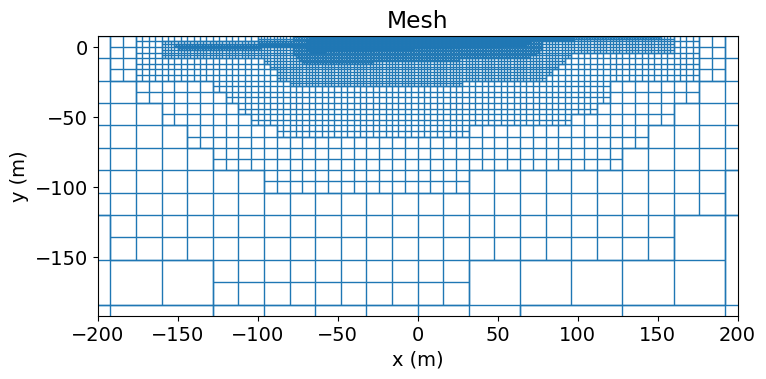

In [12]:
# Plot the mesh
fig = plt.figure(figsize=(8, 4))

ax1 = fig.add_axes([0.14, 0.17, 0.8, 0.7])
mesh.plot_grid(ax=ax1, linewidth=1)
ax1.grid(False)
ax1.set_xlim(-200, 200)
ax1.set_ylim(np.max(y_topo) - 200, np.max(y_topo))
ax1.set_title("Mesh")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

plt.show()

### <span style="color:darkgreen">Exercise (beginner):</span>

The mesh is another object whose properties we can extract. Try to extract the following properties from the mesh:

- the total number of cells
- the number of x-faces
- the origin
- the largest cell size
- the cell centers

In [13]:
print("# of cells: {}".format(mesh.n_cells))  # Number of cells
print("# of x-faces: {}".format(mesh.n_faces_x))  # Number of x-faces
print("Origin: {}".format(mesh.origin))  # bottom-southwest corner
print("Max cell volume: {}".format(mesh.cell_volumes.max()))  # Largest cell size
print(mesh.cell_centers[0:5, :])  # Cell center locations

# of cells: 9917
# of x-faces: 9849
Origin: [-512.         -504.02017958]
Max cell volume: 65536.0
[[-448.         -440.02017958]
 [-320.         -440.02017958]
 [-448.         -312.02017958]
 [-320.         -312.02017958]
 [-192.         -440.02017958]]


## Step 4: Active Cells

<img src="https://raw.githubusercontent.com/simpeg/agrogeo24/main/images/active_cells.png" width="25%" align="right"/>

Simulated geophysical data are dependent on the subsurface distribution of physical property values. As a result, the cells lying below the surface topography are commonly referred to as 'active cells'. And air cells, whose physical property values are fixed, are commonly referred to as 'inactive cells'. 

### <span style="color:darkgreen">Exercise (beginner):</span>

Use the [active_from_xyz](https://discretize.simpeg.xyz/en/main/api/generated/discretize.utils.active_from_xyz.html) utility function define the active mesh cells. The input arguments for the function are the

* **mesh** (the tree mesh)
* **topo_2d** (2D topography)

The output quantity is a ``bool`` array which should be named **active_cells**.

In [14]:
# Indices of the active mesh cells from topography (e.g. cells below surface)
active_cells = active_from_xyz(mesh, topo_2d)

In [15]:
# number of active cells
n_active = np.sum(active_cells)

## Step 5: Defining a Model

In SimPEG, the term 'model' is not synonymous with physical property values defined for all mesh cells. For example, the model parameters may represent log-resistivities, or only define physical properties on the active mesh cells. Models in SimPEG are 1D numpy.ndarray whose lengths are equal to the number of model parameters.

### <span style="color:darkgreen">Exercise (beginner):</span>

Generate a model whose parameters define the resistivities ($\Omega m$) on all active mesh cells. The model will have the following features:

* Near surface resistivity of 100 $\Omega m$
* Basement resistivity (z < -16 m) of 10 $\Omega m$
* A block with a resistivity of 1000 $\Omega m$. The bottom-left corner is at (5, -10) and the top-right corner is at (15, 0)

*For simple geometric shapes, we can use utilities like* [model_builder.get_indices_block](https://docs.simpeg.xyz/content/api/generated/SimPEG.utils.model_builder.get_indices_block.html). Note that for a 2D geometry, objects extend to infinity in the direction into/out of the page.

### <span style="color:darkorange">Exercise (advanced):</span>

Generate a model whose parameters define the log-resistivities (natural log) on all active mesh cells.

In [16]:
air_resistivity = 1e8
background_resistivity = 1e2
block_resistivity = 1e3
basement_resistivity = 1e1

In [17]:
# Define resistivity model
resistivity_model = background_resistivity * np.ones(mesh.n_cells)

ind_basement = mesh.cell_centers[:, -1] < -16.0
resistivity_model[ind_basement] = basement_resistivity

ind_block = model_builder.get_indices_block(
    np.r_[5.0, -10.0], np.r_[15.0, 0], mesh.cell_centers
)
resistivity_model[ind_block] = block_resistivity

resistivity_model = resistivity_model[active_cells]

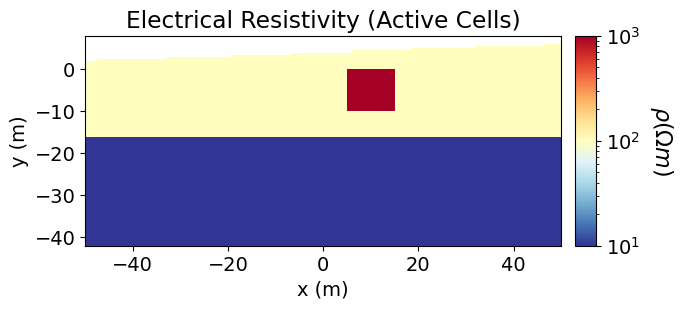

In [18]:
# Generate a mapping to ignore inactive cells in plot
plotting_map = maps.InjectActiveCells(mesh, active_cells, np.nan)

fig = plt.figure(figsize=(7, 3))

norm = LogNorm(vmin=1e1, vmax=1e3)

ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
mesh.plot_image(
    plotting_map * resistivity_model,
    ax=ax1,
    grid=False,
    pcolor_opts={"norm": norm, "cmap": mpl.cm.RdYlBu_r},
)
ax1.set_xlim(-50, 50)
ax1.set_ylim(np.max(topo_2d[:, -1]) - 50, np.max(topo_2d[:, -1]))
ax1.set_title("Electrical Resistivity (Active Cells)")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.84, 0.17, 0.03, 0.7])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label(r"$\rho (\Omega m)$", rotation=270, labelpad=25, size=16)

plt.show()

## Step 6: Mapping from the Model to the Mesh

In step 5, we learned that models are not synonymous with the physical property values for all mesh cells. However, the forward simulation requires the resistivities on the entire mesh to simulate data. As a result, we must define a mapping from our model parameters to the resistivities on the mesh. The mapping depends on how you chose to define you model parameters. In SimPEG, mappings are defined using classes within the [SimPEG.maps](https://docs.simpeg.xyz/content/api/SimPEG.html#mappings) module.



### <span style="color:darkgreen">Exercise (beginner):</span>

In this case, the model represents the electrical resistivity values for all active cells. We must define a mapping that projects these values to the entire mesh AND sets a static value for all air cells. Use the [SimPEG.maps.InjectActiveCells](myst:SimPEG#SimPEG.maps.InjectActiveCells) mapping to define this mapping. **Important:** although the true electrical resistivity of the air is infinity, set the value for the inactive cells to 1e8 $\Omega m$ to ensure the linear system constructed to solve the PDE for the DC resistivity problem is well-conditioned.

<img src="https://raw.githubusercontent.com/simpeg/agrogeo24/main/images/mapping_1.png" width="45%" align="center"/>

### <span style="color:darkorange">Exercise (advanced):</span>

In this case, the model represents log-resistivity values for all active cells. Here, we must define a mapping that 

- converts log-resistivities to resistivities, then
- projects these values to the entire mesh AND sets a static value for all air cells.

<img src="https://raw.githubusercontent.com/simpeg/agrogeo24/main/images/mapping_2.png" width="75%" align="center"/>

Use the [SimPEG.maps.InjectActiveCells](https://docs.simpeg.xyz/content/api/generated/SimPEG.maps.InjectActiveCells.html#SimPEG.maps.InjectActiveCells) and [SimPEG.maps.ExpMap](https://docs.simpeg.xyz/content/api/generated/SimPEG.maps.ExpMap.html#SimPEG.maps.ExpMap) mappings to accomplish this. Successive mappings can be combined via the chain rule using the $^*$ operator; i.e.

```
rho_map = active_map * exp_map
```

In [20]:
# Conductivity map. Model parameters are conductivities for all active cells.
inject_active_cells = maps.InjectActiveCells(mesh, active_cells, air_resistivity)

## Step 7: Project Survey to Discretized Topography

<img src="https://raw.githubusercontent.com/simpeg/agrogeo24/main/images/project_electrodes.png" width="40%" align="right"/>

Surface DC resistivity data will not be modeled accurately if the electrodes are modeled as living above or below the surface. It is especially problematic when electrodes are modeled as living in the air. Prior to simulating surface DC resistivity data, we must project the electrodes from their true elevation (red dashed line) to the surface of the *discretized* topography. From this, we can see the importance of using sufficiently small cells to discretize surface topography.

### <span style="color:darkgreen">Exercise (beginner):</span>

Use the [drape_electrodes_on_topography](https://docs.simpeg.xyz/content/api/generated/SimPEG.electromagnetics.static.resistivity.Survey.drape_electrodes_on_topography.html#SimPEG.electromagnetics.static.resistivity.Survey.drape_electrodes_on_topography) method to project surface electrodes to the discrete surface. The input arguments are:

* **mesh** (the tree mesh)
* **active_cells** (your active cells array)

This method will reassign the locations of the electrode in all source and receiver objects.

In [21]:
survey.drape_electrodes_on_topography(mesh, active_cells)

## Step 8: Defining the Forward Simulation

<img src="https://raw.githubusercontent.com/simpeg/agrogeo24/main/images/fwd_simulation.png" width="30%" align="right"/>

In SimPEG, the governing physics, problem geometry and input parameters for the forward simulation are defined within simulation classes. Here we generate an instance of [Simulation2DNodel](https://docs.simpeg.xyz/content/api/generated/SimPEG.electromagnetics.static.resistivity.Simulation2DNodal.html#SimPEG.electromagnetics.static.resistivity.Simulation2DNodal) to define the forward simulation for DC resistivity. Prior to simulating data for a given physical property model, the simulation object must be associated with a:

- survey
- mesh
- mapping from the model to the mesh

all of which we created earlier. The numerical formulation representing the governing physics is specific to each simulation class.

### <span style="color:darkgreen">Exercise (beginner):</span>

Use [dc.simulation_2d.Simulation2DNodal](https://docs.simpeg.xyz/content/api/generated/SimPEG.electromagnetics.static.resistivity.Simulation2DNodal.html#SimPEG.electromagnetics.static.resistivity.Simulation2DNodal) to define the simulation. We instantiate the simulation by setting the following:

* **mesh** (the mesh as an input argument)
* **survey=survey** (set the survey as a keyword argument)
* **rhoMap=inject_active_cells** (set the mapping as a keyword argument)

In [22]:
simulation = dc.simulation_2d.Simulation2DNodal(
    mesh, survey=survey, rhoMap=inject_active_cells
)

## Step 9: Predict DC Resistivity Data and Plot

Once any simulation within SimPEG has been properly constructed, simulated data for a given model vector can be computed using the [dpred](myst:SimPEG#SimPEG.simulation.BaseSimulation.dpred) method.

### <span style="color:darkgreen">Exercise (beginner):</span>

Use the *dpred* method to simulate DC resistivity data for your resistivity model.

In [23]:
dpred = simulation.dpred(resistivity_model)

## Plot DC Resistivity Data

Here we use the [plot_pseudosection](https://docs.simpeg.xyz/content/api/generated/SimPEG.electromagnetics.static.utils.plot_pseudosection.html#SimPEG.electromagnetics.static.utils.plot_pseudosection) utility function to represent the predicted data on a pseudosection plot as apparent conductivities. If the receivers were defined to simulate data as normalized voltages, we may want to use the [apparent_resistivity_from_voltage](https://docs.simpeg.xyz/content/api/generated/SimPEG.electromagnetics.static.utils.apparent_resistivity_from_voltage.html#SimPEG.electromagnetics.static.utils.apparent_resistivity_from_voltage) utility function to convert the data to apparent resistivities.

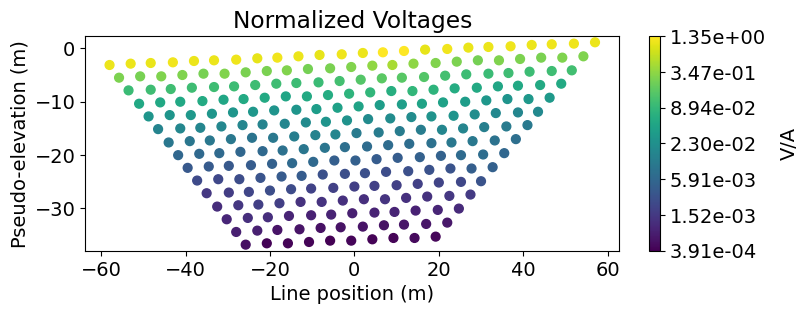

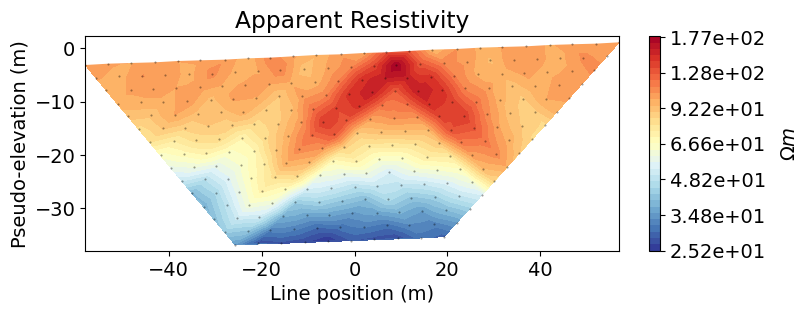

In [24]:
# Plot voltages pseudo-section
if data_type == "volt":
    fig = plt.figure(figsize=(8, 2.75))
    ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
    plot_pseudosection(
        survey,
        dobs=np.abs(dpred),
        plot_type="scatter",
        ax=ax1,
        scale="log",
        cbar_label="V/A",
        scatter_opts={"cmap": mpl.cm.viridis},
    )
    ax1.set_title("Normalized Voltages")
    plt.show()

    # Get apparent conductivities from volts and survey geometry
    apparent_resistivity = apparent_resistivity_from_voltage(survey, dpred)

else:
    apparent_resistivity = dpred.copy()

# Plot apparent resistivity pseudo-section
fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    survey,
    dobs=apparent_resistivity,
    data_locations=True,
    plot_type="contourf",
    ax=ax1,
    scale="log",
    cbar_label="$\Omega m$",
    mask_topography=True,
    contourf_opts={"levels": 40, "cmap": mpl.cm.RdYlBu_r},
)
ax1.set_title("Apparent Resistivity")
plt.show()

## Optional: Write out dpred

Write DC resistivity data, topography, and true model




In [25]:
if write_output:
    dir_path = os.path.sep.join([".", "fwd_dcr_2d_outputs"]) + os.path.sep
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

    # Add 5% Gaussian noise to each datum
    np.random.seed(225)
    std = 0.08 * np.abs(dpred)
    dc_noise = std * np.random.normal(size=len(dpred))
    dobs = dpred + dc_noise

    # Create a survey with the original electrode locations
    # and not the shifted ones
    # Generate source list for DC survey line
    source_list = generate_dcip_sources_line(
        survey_type,
        data_type,
        dimension_type,
        end_locations,
        topo_2d,
        num_rx_per_src,
        station_separation,
    )
    survey_original = dc.Survey(source_list)

    # Write out data at their original electrode locations (not shifted)
    data_obj = data.Data(survey_original, dobs=dobs, standard_deviation=std)
    fname = dir_path + "dc_data.obs"
    write_dcip2d_ubc(fname, data_obj, "volt", "dobs")

    fname = dir_path + "topo_2d.txt"
    np.savetxt(fname, topo_2d, fmt="%.4e")